In [1]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import scipy
import scipy.ndimage as ndi
from skimage import (
    color, filters, exposure, measure, morphology, transform, util)
from segmentflow import segment, view
from tqdm.notebook import tqdm
%load_ext autoreload
%autoreload 2

## Load images

In [2]:
int(1/0.09)

11

In [3]:
def load_rescaled_images(
    imgs_path, scale, file_suffix=".tif", convert_to_unit8=False
):
    imgs_path = Path(imgs_path)
    img_path_list = [
            path for path in imgs_path.glob(f'*{file_suffix}')]
    img0 = iio.imread(img_path_list[0])
    img0 = transform.rescale(img0, scale, anti_aliasing=False)
    imgs = np.zeros(
        (len(img_path_list) // int(1/scale) + 1, img0.shape[0], img0.shape[1]))
    if convert_to_unit8:
        imgs = imgs.astype(np.uint8)
    for new_i, og_i in tqdm(enumerate(
        range(0, len(img_path_list), int(1/scale))
    )):
        img = iio.imread(img_path_list[og_i])
        img_rs = transform.rescale(img, scale, anti_aliasing=False)
        if convert_to_unit8:
            imgs[new_i, ...] = util.img_as_ubyte(img_rs)
        else:
            imgs[new_i, ...] = img_rs
    return imgs

0it [00:00, ?it/s]

Data shape:  (219, 169, 160)
Data type:  uint8
--> Plotting images: [  0  27  54  81 109 136 163 190 218]


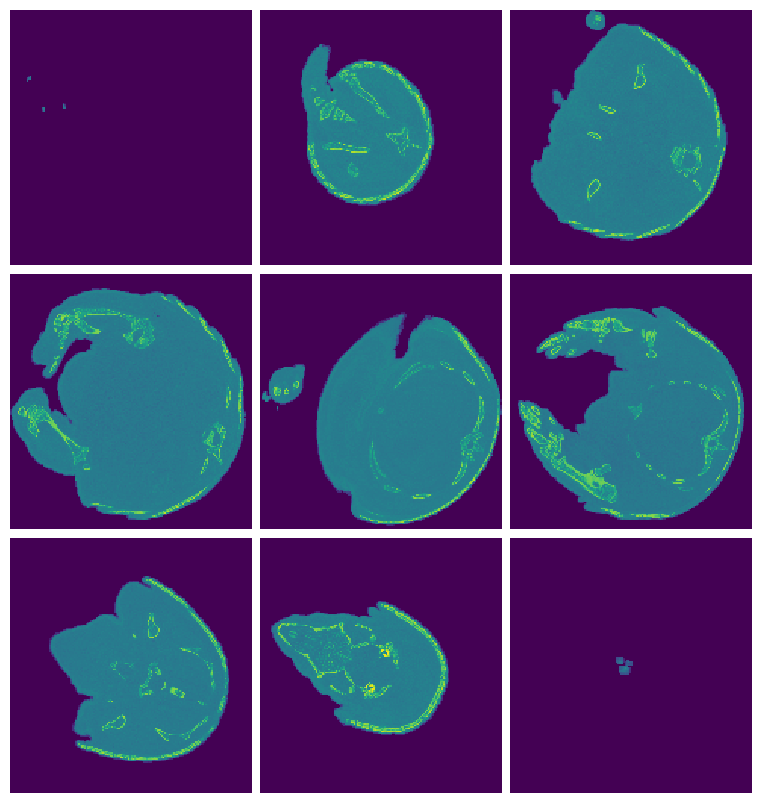

In [4]:
imgs_path = Path('data/armadillo-UF20650')
imgs = load_rescaled_images(
    imgs_path, 0.10, file_suffix='.tif', convert_to_unit8=True)
print('Data shape: ', imgs.shape)
print('Data type: ', imgs.dtype)
fig, axes = view.plot_slices(
    imgs,
    nslices=9,
    print_slices=True,
    imgs_per_row=3,
    fig_w=7.5,
    dpi=100
)

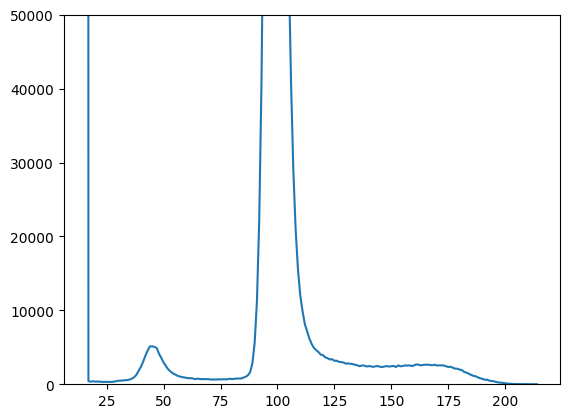

In [5]:
hist, bins_centers = exposure.histogram(imgs)
fig, ax = plt.subplots()
ax.plot(bins_centers, hist)
ax.set_ylim([0, 5e4])
plt.show()

## Semantic seg

--> Plotting images: [  0  27  54  81 109 136 163 190 218]


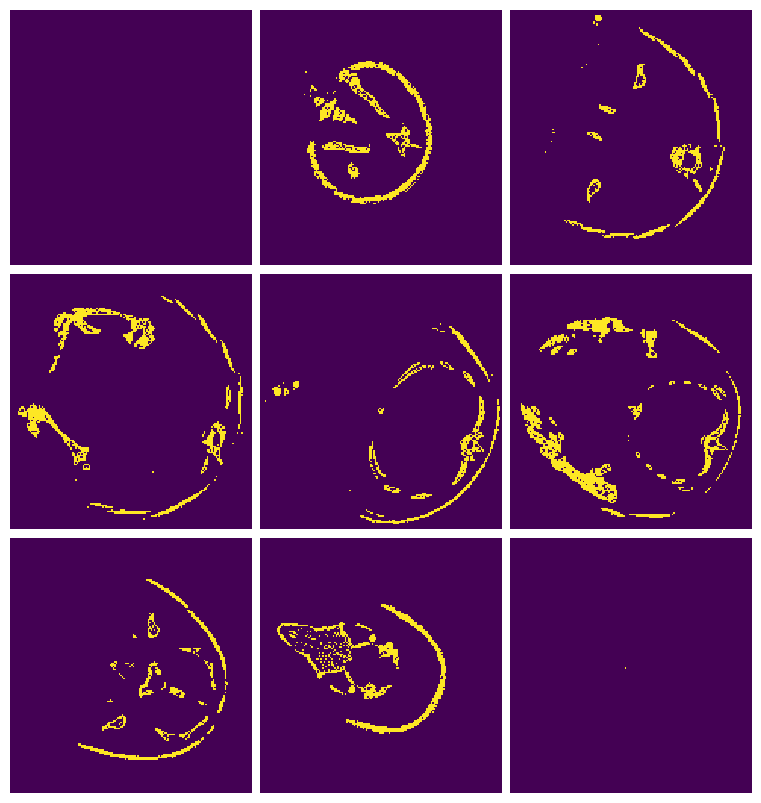

In [6]:
thresholds = [110]
imgs_semantic = segment.isolate_classes(imgs, thresholds)
fig, axes = view.plot_slices(
    imgs_semantic,
    nslices=9,
    print_slices=True,
    imgs_per_row=3,
    fig_w=7.5,
    dpi=100
)

In [7]:
pts = np.array(np.nonzero(imgs_semantic))
pts.shape

(3, 232052)

## Clean image

--> Plotting images: [  0  27  54  81 109 136 163 190 218]


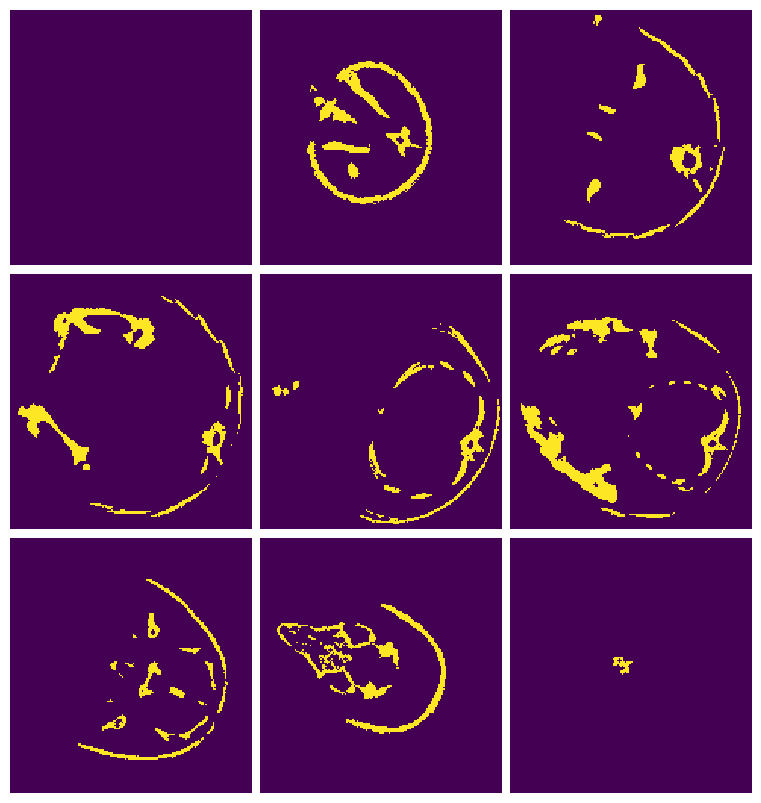

In [8]:
imgs_cleaned = morphology.binary_closing(imgs_semantic)
imgs_cleaned = ndi.binary_fill_holes(imgs_cleaned)
imgs_cleaned = morphology.remove_small_objects(imgs_cleaned, 10)
fig, axes = view.plot_slices(
    imgs_cleaned,
    nslices=9,
    print_slices=True,
    imgs_per_row=3,
    fig_w=7.5,
    dpi=100
)

## Make shell

--> Plotting images: [  0  27  54  81 109 136 163 190 218]


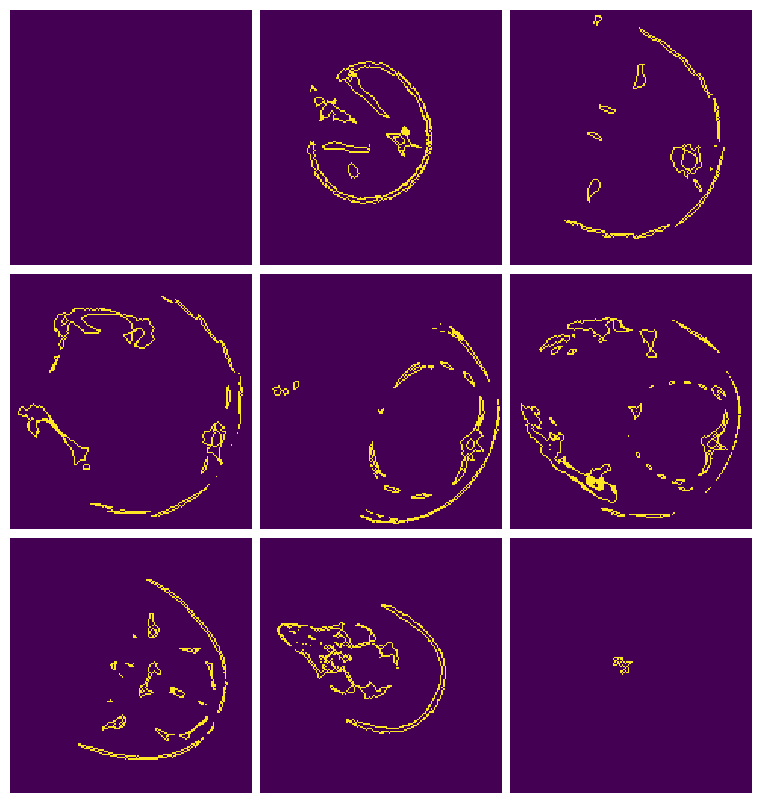

In [9]:
imgs_ero = morphology.binary_erosion(imgs_cleaned)
imgs_shell = np.logical_xor(imgs_cleaned, imgs_ero)
fig, axes = view.plot_slices(
    imgs_shell,
    nslices=9,
    print_slices=True,
    imgs_per_row=3,
    fig_w=7.5,
    dpi=100
)

In [10]:
pts = np.array(np.nonzero(imgs_shell))
print(pts.shape)
df = pd.DataFrame(pts.T, columns=['z', 'y', 'x'])
df.head()

(3, 166503)


,z,y,x
0,2,73,68
1,2,74,69
2,2,76,70
3,2,77,70
4,2,77,72


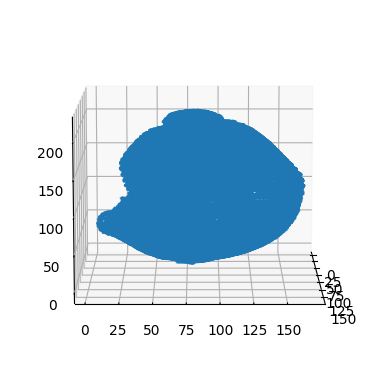

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df['x'].to_numpy(), df['y'].to_numpy(), df['z'].to_numpy(), s=1)
ax.view_init(elev=10, azim=0)

## Segment

Segmenting images...
--> Segmentation complete. 225 particle(s) segmented.
--> Plotting images: [  0  27  54  81 109 136 163 190 218]


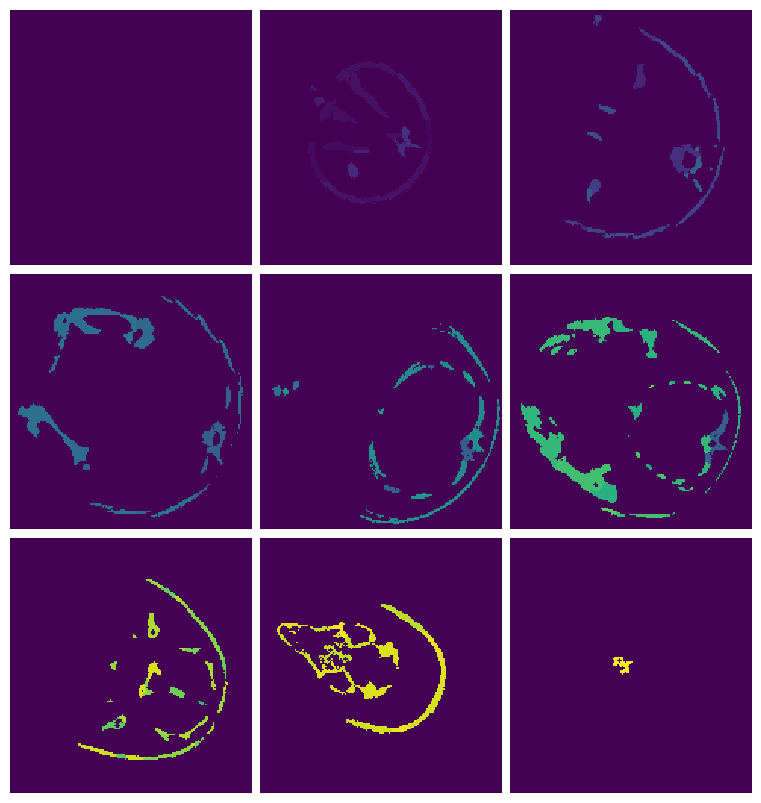

In [12]:
imgs_seg_10msd = segment.watershed_segment(imgs_cleaned, min_peak_distance=10)
fig, axes = view.plot_slices(
    imgs_seg_10msd,
    nslices=9,
    print_slices=True,
    imgs_per_row=3,
    fig_w=7.5,
    dpi=100
)

In [16]:
np.unique(imgs_seg_10msd).shape

(226,)

### Save meshes

In [18]:
segment.save_as_stl_files(
    imgs_seg_10msd,
    Path('results/'),
    '10msd'
)


Generating surface meshes...
Surface mesh not created for particle 128. Particle likely too small. Error:  No surface found at the given iso value.
--> 224 STL file(s) written!
